In [2]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from  hmcSampler import HMCSampler

def dU(q):
    return np.sum((y - f(q,x))*(-1.0*df(q,x)), axis=2)

def U(q):
    return np.sum((y - f(q,x))**2,axis=1)/2.0

def f(q,x):
    return np.polynomial.polynomial.polyval(x,q)
 
def df(q,x):
    r = np.transpose(np.asarray([dx]*q.shape[1]),(1,0,2))
    return r


In [3]:
global y
global x
global dx

x = np.linspace(-2.0,2.0,100)
p = np.asarray([2.0,5.0,1.0,1.0])
y = f(p,x) + np.random.randn(len(x))

indicies = np.arange(len(p))
xp = (x*np.ones((len(p),len(x)))).T
dx = np.power(xp,indicies).T

smp = HMCSampler()
smp.U = U
smp.dU = dU
smp.qi = np.asarray([1.5,4.0,0.0,0.0])
smp.n_samples = 2000
smp.n_burnin = 1000
smp.steps = 50
smp.epsilon = 0.001

y0 = f(smp.qi,x)

smp.runHMC()

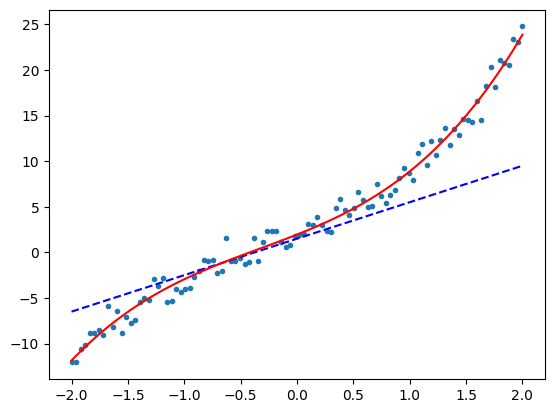

In [7]:
smp.samples = np.reshape(smp.samples,(smp.n_samples*smp.n_walkers,len(smp.qi)))

py = f((np.median(smp.samples,axis=0)),x)
plt.plot(x,y,'.')
plt.plot(x,y0,'b--')
plt.plot(x,py,'r-')
plt.show()


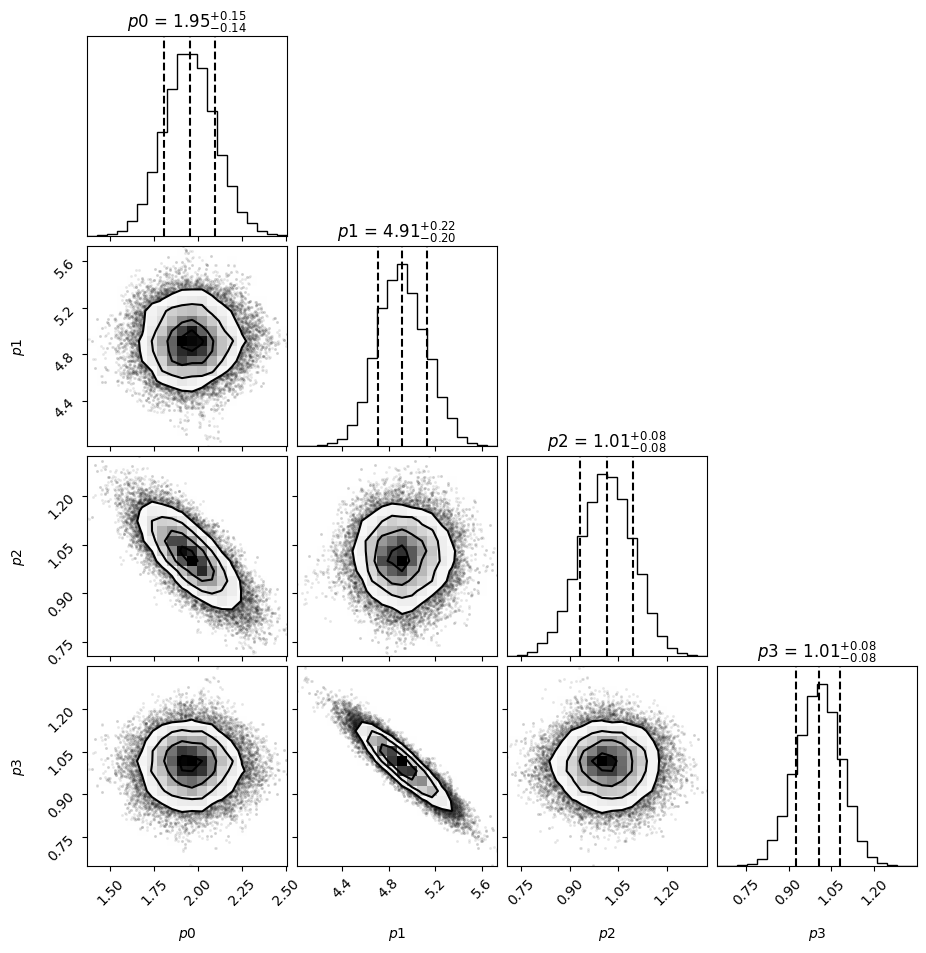

In [8]:
figure = corner.corner(
smp.samples,
labels=[
    r"$p0$",
    r"$p1$",
    r"$p2$",
    r"$p3$"],
quantiles=[0.16, 0.5, 0.84],
show_titles=True,
title_kwargs={"fontsize": 12})

plt.show()